In [1]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath

from datetime import datetime
from qutip.qobj import Qobj
from collections.abc import Iterable
from typing import Callable, List, Optional, Tuple
from datetime import datetime
from scipy.integrate import odeint

In [2]:
import sys 
path = 'C:/Users/Tomas/PhD_Physics/3rd_Year/Max-Ent_Library'
sys.path.insert(1, path) 

import a_quantum_geometries as gij
import b_spin_ops as su2
import c_maxent_tools as me

In [31]:
params={}

params['size']=5
params['beta']=5.

params['omega']=4*np.pi*1.; 

params['Jx'] = 50 * 10**-3* params['omega']; params['Jy'] = .5*params['Jx']; params['chain_type']='XY'

params['Omega']=params['omega']; params['V0']=1.2; params['phase'] = np.pi/4; params['period']=2.*np.pi/params['Omega']

print(params['V0']/params['Omega'])

0.0954929658551372


In [32]:
spin_ops=su2.one_body_spin_ops(args=params)

idop=spin_ops['idop']
sx_total=sum(sx for sx in spin_ops['sx'])
sy_total=sum(sx for sx in spin_ops['sy'])
sz_total=sum(sx for sx in spin_ops['sz'])

### Lab frame Hamiltonian 
H0=params['omega']*sz_total 
Hint=su2.Heisenberg_1D_Hamiltonian(args=params,
                                   spin_ops=spin_ops,
                                   closed_bcs=True, visualization=False)
driving_lab=lambda t,args: args['V0']*np.cos(args['Omega']*t+args['phase'])
Hlab=[H0+Hint, [sx_total, driving_lab]]

### Rotating Wave Approximation

Hrwa=H0 - params['Omega']*sz_total
Hrwa+=Hint
Hrwa+=.5*params['V0']*(np.cos(params['phase'])*sx_total+np.sin(params['phase'])*sy_total)

### Rotating frame
rot_sx_tdterm=lambda t,args: .5*(np.cos(2*args['Omega']*t+args['phase']))
rot_sy_tdterm=lambda t,args: -.5*(np.sin(2*args['Omega']*t+args['phase']))

Hrwa_cr=[Hrwa, [sx_total, rot_sx_tdterm], [sy_total, rot_sy_tdterm]]

In [33]:
HBB0=[idop, sz_total]
phi0=np.array([0., -.4,])
K0 = -sum(phia * opa for phia,opa in zip(phi0, HBB0))
sigma0=gij.safe_expm_and_normalize(K=K0)

phi0[0]=np.log(sigma0.tr())
K0 = -sum(phia * opa for phia,opa in zip(phi0, HBB0))
sigma0=gij.safe_expm_and_normalize(K=K0)
HBB0+=[K0]

In [34]:
N=300
T=4*np.pi/max(.001,abs(params['V0']))/N
timespan = np.linspace(0,N*T,N)

resex=qutip.mesolve(H=Hlab,
                    rho0=K0,
                    tlist=timespan,
                    args=params)

resrwa=qutip.mesolve(H=Hrwa,
                     rho0=K0,
                     tlist=timespan,
                     args=params)

resrwacr=qutip.mesolve(H=Hrwa_cr,
                       rho0=K0,
                       tlist=timespan, 
                       args=params) 

U_rwa = lambda t,args: (-1j*sz_total*args['Omega']*t).expm()
U_rwa_td=[U_rwa(t=ti,args=params) for ti in timespan]
exact_Ks_labframe=[U_rwa_ti.dag() * Kti * U_rwa_ti for U_rwa_ti,Kti in zip(U_rwa_td,resex.states)]
rot_Ks_labframe=[U_rwa_ti.dag() * Krotti * U_rwa_ti for U_rwa_ti, Krotti in zip(U_rwa_td,resrwacr.states)]

rhos_resrwa=[gij.safe_expm_and_normalize(K=Kt) for Kt in resrwa.states]
rhos_resex=[gij.safe_expm_and_normalize(K=Kti) for Kti in exact_Ks_labframe]
rhos_rotcr=[gij.safe_expm_and_normalize(K=Kti) for Kti in rot_Ks_labframe]

In [35]:
ds=[0]
sigmas_maxent, Ks_maxent=me.multiple_projections(
                             exact_Ks=resrwa.states,
                             exact_states=rhos_resrwa,
                             generator=Hrwa, K0=K0,
                             basis0=HBB0,
                             depths=ds,
                             timespan=timespan,
                             args=params)

**** Starting Simulation 2024-04-09 21:12:52.016158
   -----Processing step 0 at time <built-in method now of type object at 0x00007FF96940C500>
   -----Processing step 30 at time <built-in method now of type object at 0x00007FF96940C500>
   -----Processing step 60 at time <built-in method now of type object at 0x00007FF96940C500>
   -----Processing step 90 at time <built-in method now of type object at 0x00007FF96940C500>
   -----Processing step 120 at time <built-in method now of type object at 0x00007FF96940C500>
   -----Processing step 150 at time <built-in method now of type object at 0x00007FF96940C500>
   -----Processing step 180 at time <built-in method now of type object at 0x00007FF96940C500>
   -----Processing step 210 at time <built-in method now of type object at 0x00007FF96940C500>
   -----Processing step 240 at time <built-in method now of type object at 0x00007FF96940C500>
   -----Processing step 270 at time <built-in method now of type object at 0x00007FF96940C500>


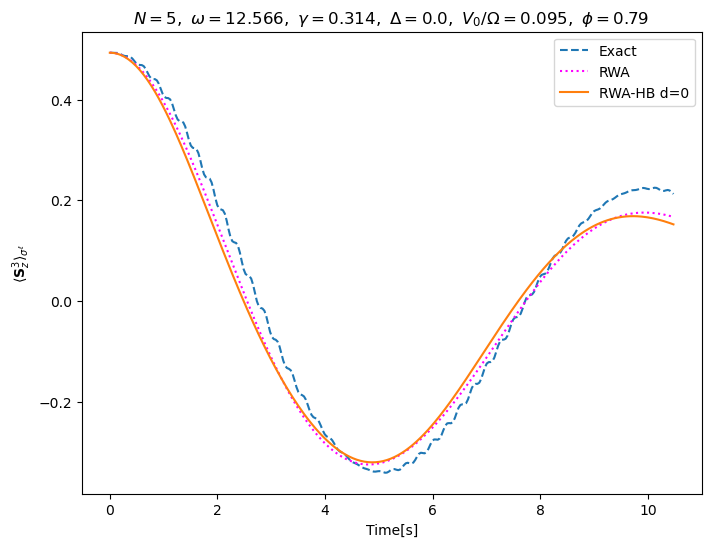

In [37]:
sz_tot_evex=np.array([(rho*sz_total).tr() for rho in rhos_resex])
sz_tot_evrwa=np.array([(sigma*sz_total).tr() for sigma in rhos_resrwa])
sz_tot_evrot=np.array([(sigma*sz_total).tr() for sigma in rhos_rotcr])
sz_tot_maxent=[np.array([(sigma_ell*sz_total).tr() for sigma_ell in sigmas_maxent_ell1]) 
                                                  for sigmas_maxent_ell1 in sigmas_maxent]

fig0,ax0=plt.subplots(figsize=(8,6))

plt.plot(timespan, sz_tot_evex, label='Exact', linestyle='dashed')
plt.plot(timespan, sz_tot_evrwa, label='RWA', linestyle='dotted', color='magenta')
#plt.plot(timespan, sz_tot_evrwa, label='Rot (CR)', color='black')
for d in ds: 
    plt.plot(timespan, sz_tot_maxent[ds.index(d)], label='RWA-HB d='+str(d))
ax0.legend(loc=0)
plt.xlabel("Time[s]")
plt.ylabel(r"$\langle {\bf S}_z^3 \rangle_{\sigma^\ell}$")
plt.title(r'$N={},\,\,\omega={},\,\, \gamma={},\,\, \Delta={},\,\, V_0/\Omega={}, \,\, \phi={}$'.format(
                                                                params['size'],
                                                                round(params['omega'],3), 
                                                                round((params['Jx']-params['Jy']),3), 
                                                                round(params['omega']-params['Omega'],3), 
                                                                round(params['V0']/params['Omega'],3),
                                                                round(params['phase'],2)))
plt.show()